In [1]:
%matplotlib notebook
import numpy as np
import pylab as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.optimize import curve_fit

from scipy.ndimage import gaussian_filter1d
from galaxies_widget import get_sn_xhdist

In [3]:
t = np.linspace(0, 13e9, 20)

In [4]:
def fgas(t, mode='', tau=11e9):
    """
    Gas fraction
    """
    if mode == 'constant':
        C = 0.7 / 13e9
        fraction = 1 - C * t
        return fraction
    
    else:
        C = 0.7 / (tau - tau * np.exp(-13e9 / tau))
        fraction = 1 - C * (tau - tau * np.exp(-t / tau))
        return fraction 

## Closed Box Model

In [5]:
Zsolar = 0.014

def calc_metallicity(t, mode='constant', tau=11e9, z_yield=0.5):
    """
    """
    return -z_yield * np.log(fgas(t, mode=mode, tau=tau))

def metallicity_distribution(Z, z_yield=0.01):
    """
    """
    Z *= Zsolar
    return Z / z_yield * np.exp(-Z / z_yield)

def fit_closed(logZ, z_yield=0.01):
    """
    """
    dN = metallicity_distribution(10 ** logZ, z_yield=z_yield)
    return dN / np.trapz(dN, logZ)

## Leaky Box Model

In [6]:
def calc_metallicity_leaky(t, mode='constant', tau=11e9, z_yield=0.01, eta=3):
    """
    """
    return -z_yield / (1 + eta) * np.log(fgas(t, mode=mode, tau=tau))

def metallicity_distribution_leaky(Z, z_yield=0.01, eta=3):
    """
    """
    Z *= Zsolar
    pp = z_yield / (1 + eta)
    return Z / pp * np.exp(-Z / pp)

def fit_leaky(logZ, z_yield=0.01, eta=3):
    """
    """
    dN = metallicity_distribution_leaky(10 ** logZ, z_yield=z_yield, eta=eta)
    return dN / np.trapz(dN, logZ)


## Accreting Box Model

In [53]:
def calc_metallicity_accreting(t, mode='constant', tau=11e9, z_yield=0.01, eta=3):
    """
    """
    return calc_metallicity_accreting_leaky(t, mode=mode, tau=tau, z_yield=z_yield, eta=eta, r=0)

def calc_metallicity_accreting_leaky(t, mode='constant', tau=11e9, z_yield=0.01, eta=3, r=0.4):
    """
    """
    return z_yield / (1 + eta - r) * (1 - np.exp((1 + eta - r) / (1 - r) * (1 - 1 / fgas(t, mode=mode, tau=tau))))


def metallicity_distribution_accreting(Z, z_yield=0.01):
    """
    """
    return 1 / z_yield * np.exp(-Z / z_yield)

def metallicity_distribution_accreting_leaky(Z, z_yield=0.01, eta=3):
    """
    """
    Z *= Zsolar
    pp = z_yield / (1 + eta)
    m = Z / (pp - Z)
    m[Z > pp] = 0
    return m

def fit_accreting(logZ, z_yield=0.01):
    """
    """
    dN = metallicity_distribution_accreting(10 ** logZ, z_yield=z_yield)
    return dN / np.trapz(dN, logZ)

def fit_accreting_leaky(logZ, z_yield=0.01, eta=3):
    """
    """
    dN = metallicity_distribution_accreting_leaky(10 ** logZ, z_yield=z_yield, eta=eta)
    k = gaussian_filter1d(np.abs(dN), 4)
    dk = k / np.trapz(k, logZ)
    return dk


## Fitting

<IPython.core.display.Javascript object>


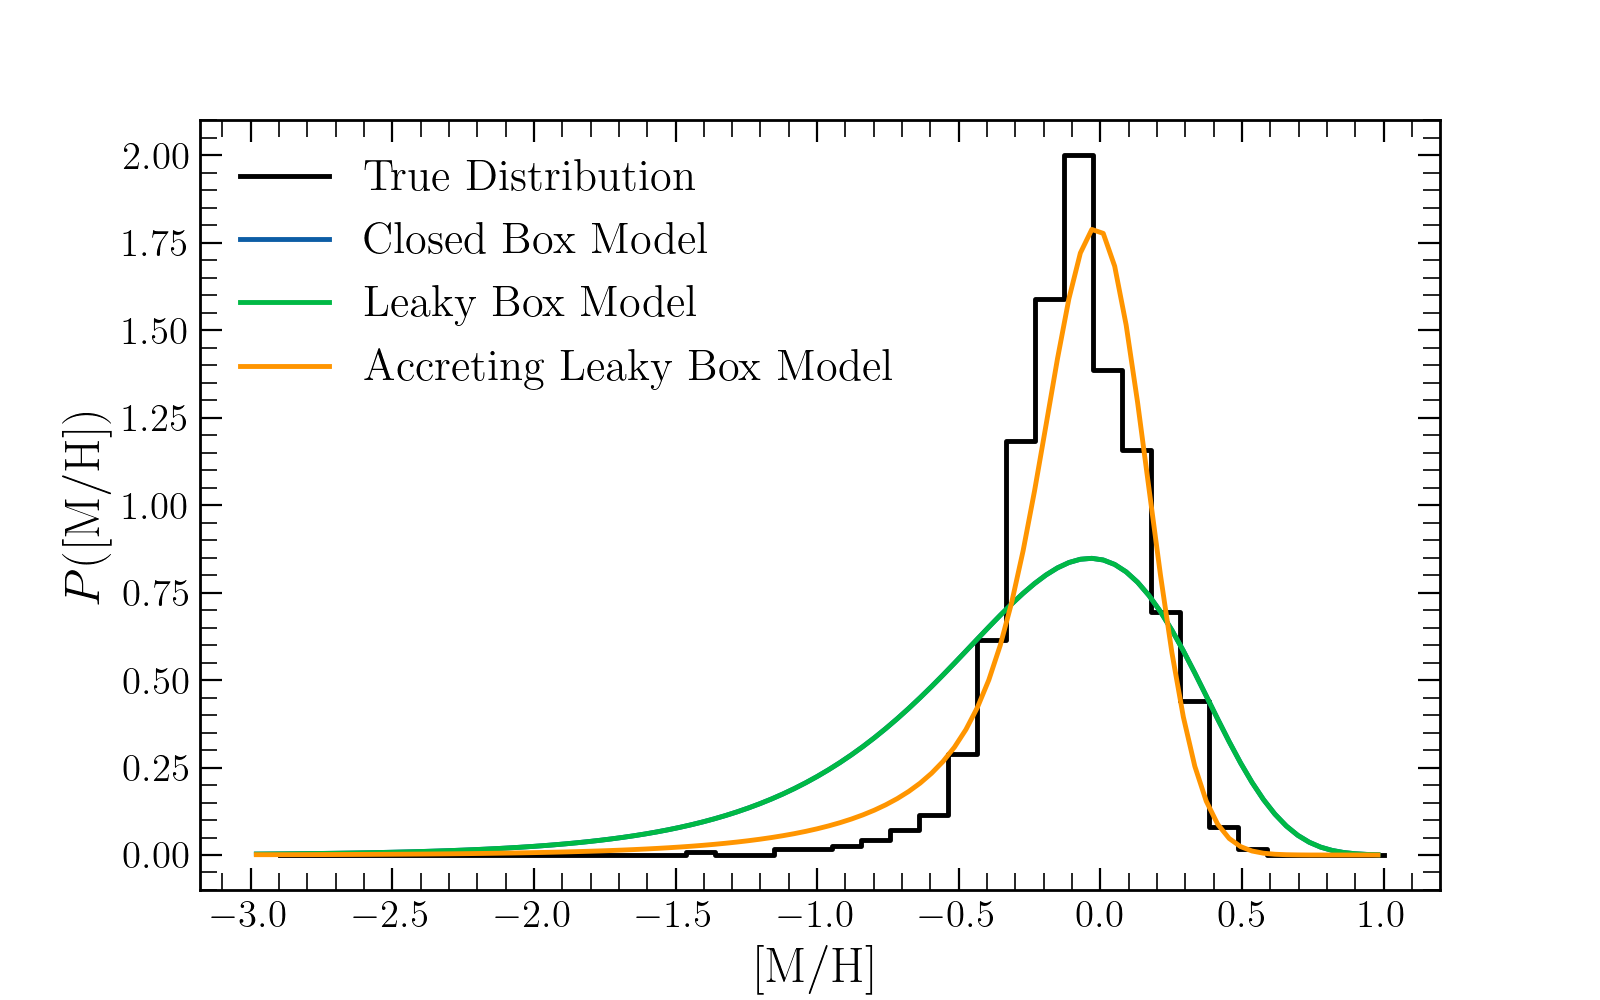

In [26]:
plt.figure(figsize=(8, 5))


# True Distribution
c, b = get_sn_xhdist("Mg", bins=np.linspace(-3, 1, 40))
plt.step(b + np.diff(b)[0] / 2, c / np.trapz(c, b), label='True Distribution', color='k')

# Fit Distribution -> Closed
c, b = get_sn_xhdist("Mg", bins=np.linspace(-3, 1, 100))
popt, pcov = curve_fit(fit_closed, b, c / np.trapz(c, b), bounds=((0.001), (0.4)))
dN = metallicity_distribution(10 ** b, z_yield=popt[0])
plt.plot(b, dN / np.trapz(dN, b), label='Closed Box Model')

# Fit Distribution -> Leaky
c, b = get_sn_xhdist("Mg", bins=np.linspace(-3, 1, 100))
popt, pcov = curve_fit(fit_leaky, b, c / np.trapz(c, b))
dN = metallicity_distribution_leaky(10 ** b, z_yield=popt[0], eta=popt[1])
plt.plot(b, dN / np.trapz(dN, b), label='Leaky Box Model')


# Fit Distribution -> Leaky Accreting
c, b = get_sn_xhdist("Mg", bins=np.linspace(-3, 1, 100))
popt, pcov = curve_fit(
    fit_accreting_leaky, b, c / np.trapz(c, b), bounds=((0.001, 0), (0.2, 10))
)

dN = metallicity_distribution_accreting_leaky(10 ** b, *popt)
k = gaussian_filter1d(np.abs(dN), 4)
plt.plot(b, k / np.trapz(k, b), label='Accreting Leaky Box Model')
plt.legend(frameon=False, fontsize=16)

plt.xlabel(r'$[\rm M/H]$')
plt.ylabel(r'$P([\rm M/H])$')
plt.show()

## Widgets

<IPython.core.display.Javascript object>


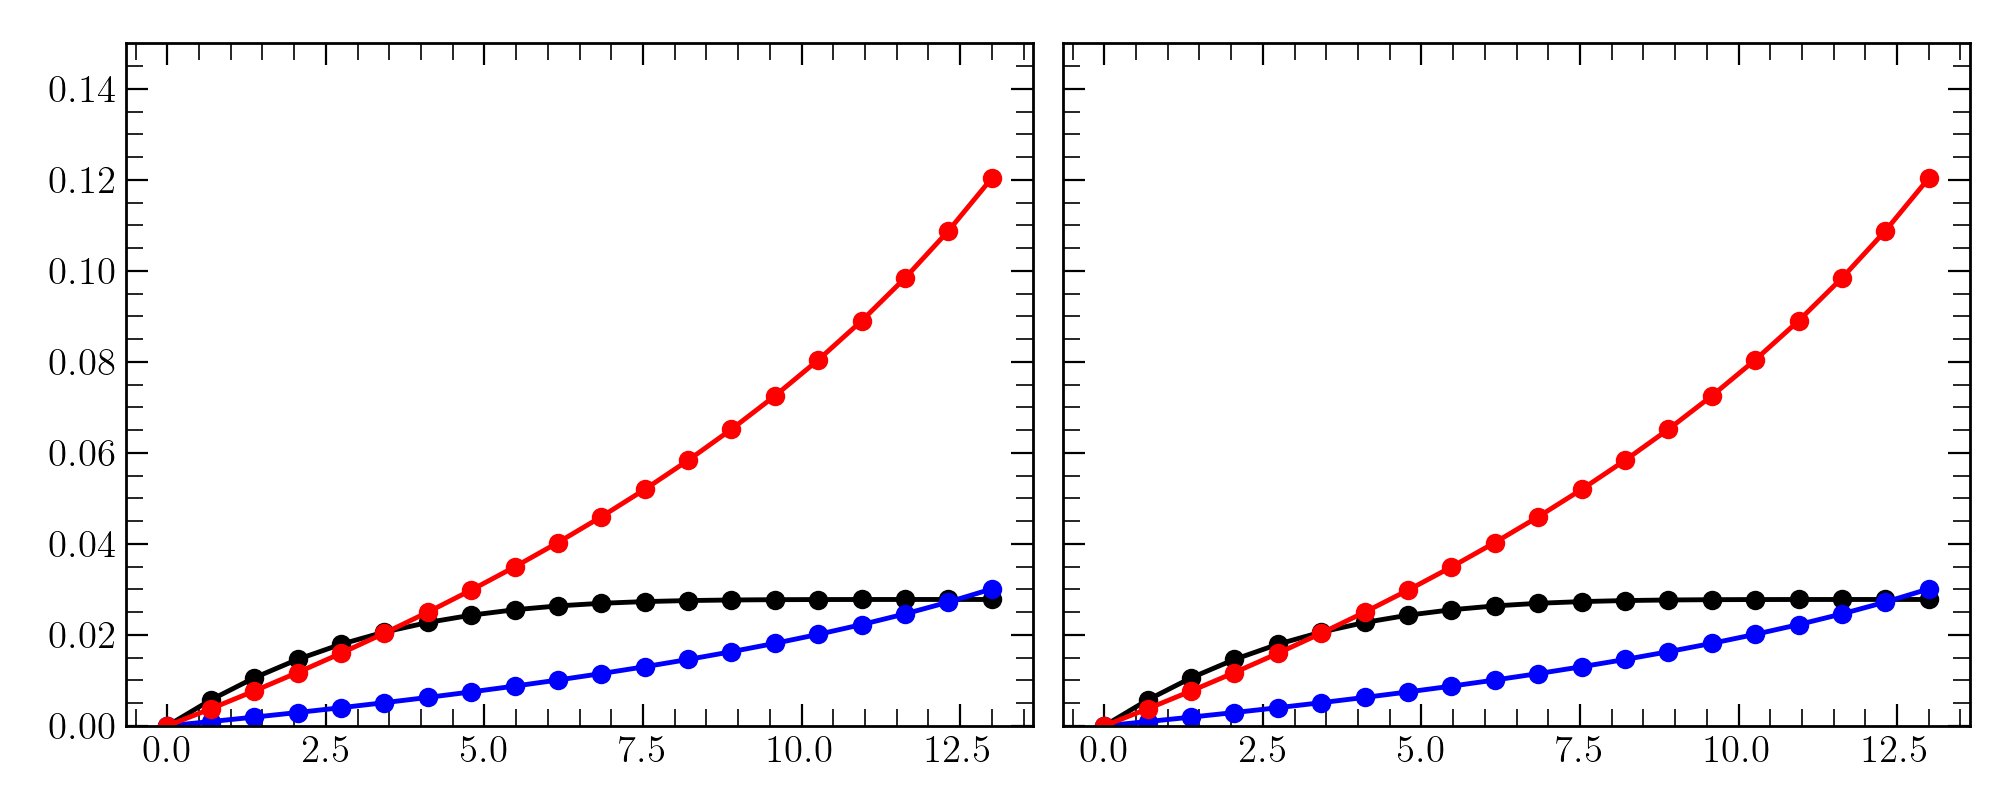

interactive(children=(FloatSlider(value=0.1, description='z_yield', max=0.1, step=0.005), FloatSlider(value=3.…

<function __main__.update(z_yield=0.5, eta=3, r=0.4)>

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax1, ax2 = axs[0], axs[1]

ti = t / 1e9

line1, = ax1.plot(ti, calc_metallicity_accreting_leaky(t), color='k', marker='o')
line2, = ax1.plot(ti, calc_metallicity_leaky(t), color='b', marker='o')
line3, = ax1.plot(ti, calc_metallicity(t), color='r', marker='o')
ax1.set_ylim([0, 0.15])

#ax2 = fig.add_subplot(1, 2, 2, sharey=ax1)
line4, = ax2.plot(ti, calc_metallicity_accreting_leaky(t), color='k', marker='o')
line5, = ax2.plot(ti, calc_metallicity_leaky(t), color='b', marker='o')
line6, = ax2.plot(ti, calc_metallicity(t), color='r', marker='o')
fig.tight_layout()

def update(z_yield=0.5, eta=3, r=0.4):
    """
    """
    g = calc_metallicity_accreting_leaky(t, z_yield=z_yield, eta=eta, r=r)
    h = calc_metallicity_leaky(t, z_yield=z_yield, eta=eta)
    i = calc_metallicity(t, z_yield=z_yield)
    line1.set_ydata(g)
    line2.set_ydata(h)
    line3.set_ydata(i)
    line4.set_ydata(g)
    line5.set_ydata(h)
    line6.set_ydata(i)
    fig.canvas.draw()
    
interact(update, z_yield=(0.0, 0.1, 0.005), eta=(0, 5, 0.05), r=(0, 0.9, 0.05))